# PAGES 2k updates with Python tools

## Authors

[Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751) &
[Deborah Khider](https://orcid.org/0000-0001-7501-8430)

### Goal

 Integrate various code and data resources from the LinkedEarth/PReSto Python ecosystem to produce an updated climate field reconstruction of the climate of the Common Era (last 2,000 years). 
                                                                   

## Data Description

This notebook makes use of the `LiPDGraph` database, a graph database that contains datasets from various working groups. For a list of these compilations, see [this page](https://lipdverse.org/project/). 

In particular, we will be using PAGES2k and iso-2k for this demonstration.

* PAGES2k: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). doi:10.1038/sdata.2017.88

* iso2k: Konecky, B. L., McKay, N. P., Churakova (Sidorova), O. V., Comas-Bru, L., Dassié, E. P., DeLong, K. L., Falster, G. M., Fischer, M. J., Jones, M. D., Jonkers, L., Kaufman, D. S., Leduc, G., Managave, S. R., Martrat, B., Opel, T., Orsi, A. J., Partin, J. W., Sayani, H. R., Thomas, E. K., Thompson, D. M., Tyler, J. J., Abram, N. J., Atwood, A. R., Cartapanis, O., Conroy, J. L., Curran, M. A., Dee, S. G., Deininger, M., Divine, D. V., Kern, Z., Porter, T. J., Stevenson, S. L., von Gunten, L., and Iso2k Project Members: The Iso2k database: a global compilation of paleo-δ18O and δ2H records to aid understanding of Common Era climate, Earth Syst. Sci. Data, 12, 2261–2288, https://doi.org/10.5194/essd-12-2261-2020, 2020.

* CoralHydro2k:  Walter, R. M., H. R. Sayani, T. Felis, K. M. Cobb, N. J. Abram, A. K. Arzey, A. R. Atwood, L. D.
Brenner, E. P. Dassi ́e, K. L. DeLong, B. Ellis, J. Emile-Geay, M. J. Fischer, N. F. Goodkin, J. A.
Hargreaves, K. H. Kilbourne, H. Krawczyk, N. P. McKay, A. L. Moore, S. A. Murty, M. R. Ong,
R. D. Ramos, E. V. Reed, D. Samanta, S. C. Sanchez, J. Zinke, and the PAGES CoralHydro2k Project Members (2023), The CoralHydro2k database: a global, actively curated compilation of coral δ18O and Sr / Ca proxy records of tropical ocean hydrology and temperature for the Common Era, Earth System Science Data, 15(5), 2081–2116, doi:10.5194/essd-15-2081-2023.

## Data Retrieval

Following [this tutorial](http://linked.earth/pylipdTutorials/notebooks/L2_using_graphdb.html), we perform a [SPARQL query](http://linked.earth/pylipdTutorials/graph.html#what-is-sparql) on the [LiPDverse](https://lipdverse.org) to assemble the most current dataset. We need a few packages do to so, both general-purpose ones [pandas](https://pandas.pydata.org) and paleoclimate-centric ones like [Pyleoclim](https://github.com/LinkedEarth/Pyleoclim_util) and [cfr](https://fzhu2e.github.io/cfr/):

In [1]:
import json
import requests
import pandas as pd
import io
import ast
import numpy as np
import pyleoclim as pyleo
import seaborn as sns
import cfr

Point toward the database:

In [2]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse-dynamic'

### SPARQL queries

In the first query, we retrieve all the data in the PAGES2k and iso2k compilations that were tagged to be used in the temperature analysis for this compilations along with metadata regarding the location, the type of archive and proxy used. In a separate query, we gather data corresponding to CoralHydro2k. The reason why we cannot gather all 3 with one query is that the tag `useInGlobalTemperatureAnalysis` is present in the first two, but not the latter. 

Each column is stored separately, so we also need to go grab the time axis. The query is as follows:

In [3]:
query1 = """PREFIX le: <http://linked.earth/ontology#>
PREFIX le_var: <http://linked.earth/ontology/variables#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?dataSetName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?time_variableName ?time_values 
	?time_units ?compilationName ?TSID where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
        
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL {?loc wgs84:alt ?geo_meanElev .}

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasValues ?paleoData_values .
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .
    VALUES ?compilationName {"iso2k" "Pages2kTemperature"} .
    ?var le:useInGlobalTemperatureAnalysis True .
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .
        
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable le_var:year .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }
}"""



For an explanation, see [this tutorial](http://linked.earth/pylipdTutorials/notebooks/L2_using_graphdb.html). For results, let's just send our query over to the server and get the results into a pandas dataframe:

In [4]:
response = requests.post(url, data = {'query': query1})

data = io.StringIO(response.text)
df1 = pd.read_csv(data, sep=",")

In [5]:
df1.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,compilationName,TSID
0,LS16STCL,Lake sediment,50.8300,-116.3900,1126.0,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,NaN,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",yr AD,iso2k,LPD7dc5b9ba
1,CO00URMA,Coral,0.9330,173.0000,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",yr AD,iso2k,Ocean2kHR_177
2,CO05KUBE,Coral,32.4670,-64.7000,-12.0,d18O,"[-4.15, -3.66, -3.69, -4.07, -3.95, -4.12, -3....",permil,d18O,NaN,year,"[1983.21, 1983.13, 1983.04, 1982.96, 1982.88, ...",yr AD,iso2k,Ocean2kHR_105
3,IC13THQU,Glacier ice,-13.9333,-70.8333,5670.0,d18O,"[-18.5905, -16.3244, -16.2324, -17.0112, -18.6...",permil,d18O,NaN,year,"[2009, 2008, 2007, 2006, 2005, 2004, 2003, 200...",yr AD,iso2k,SAm_035
4,CO01TUNG,Coral,-5.2170,145.8170,-3.0,d18O,"[-4.875, -4.981, -5.166, -5.06, -4.942, -4.919...",permil,d18O,NaN,year,"[1993.042, 1992.792, 1992.542, 1992.292, 1992....",yr AD,iso2k,Ocean2kHR_141


In [6]:
query2 = """PREFIX le: <http://linked.earth/ontology#>
PREFIX le_var: <http://linked.earth/ontology/variables#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?dataSetName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?time_variableName ?time_values 
	?time_units ?compilationName ?TSID where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
        
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL {?loc wgs84:alt ?geo_meanElev .}

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasValues ?paleoData_values .
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .
    VALUES ?compilationName {"CoralHydro2k"} .
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .
        
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable le_var:year .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }
}"""

In [7]:
response = requests.post(url, data = {'query': query2})
data = io.StringIO(response.text)
df2 = pd.read_csv(data, sep=",")
df2.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,compilationName,TSID
0,KA17RYU01,Coral,28.300,130.000,-3.5,SrCa,"[8.802, 9.472, 8.825, 9.355, 8.952, 9.297, 8.8...",mmol/mol,NaN,NaN,year,"[1578.58, 1579.08, 1579.58, 1580.08, 1580.58, ...",yr AD,CoralHydro2k,KA17RYU01_SrCa
1,CH18YOA02,Coral,16.448,111.605,NaN,SrCa,"[8.58, 8.683, 8.609, 8.37, 8.38, 8.417, 8.584,...",mmol/mol,NaN,NaN,year,"[1987.92, 1988.085, 1988.25, 1988.42, 1988.585...",yr AD,CoralHydro2k,CH18YOA02_SrCa
2,FL17DTO02,Coral,24.699,-82.799,-3.0,SrCa,"[9.159, 9.257, 9.245, 9.166, 9.045, 9.013, 8.9...",mmol/mol,NaN,NaN,year,"[1837.04, 1837.13, 1837.21, 1837.29, 1837.38, ...",yr AD,CoralHydro2k,FL17DTO02_SrCa
3,BO14HTI01,Coral,12.210,109.310,-3.6,d18O,"[-5.4206, -5.3477, -5.1354, -5.7119, -5.9058, ...",permil,NaN,NaN,year,"[1977.37, 1977.45, 1977.54, 1977.62, 1977.7, 1...",yr AD,CoralHydro2k,BO14HTI01_d18O
4,BO14HTI01,Coral,12.210,109.310,-3.6,SrCa,"[9.2, 9.17, 9.11, 9.02, 8.95, 8.99, 9.06, 9.1,...",mmol/mol,NaN,NaN,year,"[1600.04, 1600.12, 1600.2, 1600.28, 1600.37, 1...",yr AD,CoralHydro2k,BO14HTI01_SrCa


Now let's merge the dataframes. First, confirm they have the same number of columns:

In [8]:
df = pd.concat([df1, df2])
df.shape

(919, 15)

### Data Processing


Much like [PyLiPD](http://linked.earth/pylipdTutorials/intro.html), the information is contained in columns with each row representing a time series. For efficiency reasons, the data are stored as strings, so we need to convert each row to numpy arrays or list. Here is a way to do so:

In [9]:
df['paleoData_values']=df['paleoData_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df['time_values']=df['time_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)


Now we need to put the data into a form that [cfr](https://fzhu2e.github.io/cfr/) can work with. We now adapt [this example](https://khider.github.io/DISK-proxyComposite/intro.html). First, let's see what columns we have in our dataframe:

In [10]:
df.columns

Index(['dataSetName', 'archiveType', 'geo_meanLat', 'geo_meanLon',
       'geo_meanElev', 'paleoData_variableName', 'paleoData_values',
       'paleoData_units', 'paleoData_proxy', 'paleoData_proxyGeneral',
       'time_variableName', 'time_values', 'time_units', 'compilationName',
       'TSID'],
      dtype='object')

Let's confirm that we have all three compilations in here:

In [11]:
pd.unique(df['compilationName'])

array(['iso2k', 'Pages2kTemperature', 'CoralHydro2k'], dtype=object)

Let's inspect this dataset by archive and variable type:

In [12]:
temp = df[['archiveType','paleoData_variableName']]

temp.groupby(['archiveType','paleoData_variableName'], as_index=False).value_counts()

,archiveType,paleoData_variableName,count
0,Borehole,temperature,2
1,Coral,SrCa,100
2,Coral,Sr_Ca,24
3,Coral,calcification,2
4,Coral,composite,6
5,Coral,d18O,240
6,Coral,d18O_sw,19
7,Coral,temperature,1
8,Documents,temperature,14
9,Glacier ice,d18O,16


However, there are duplicates that belong to more than 1 compilation. Thankfully, [cfr can deal with that](https://fzhu2e.github.io/cfr/notebooks/proxy-dups.html)


### Metadata Cleaning
`cfr` needs a field call `ptype` that is a juxtaposition of the archive and observation type (e.g. 'coral.d18O'). For this to work, those strings first need to be  aligned to the [LiPDverse controlled vocabularies](https://lipdverse.org/vocabulary/).

In [13]:
from bs4 import BeautifulSoup

def get_vocab_synonyms(vocab='archivetype'):
    '''
    Scrape the LiPDverse website to obtain the list of possible variable names and associated synonyms
    
    Parameters
    ---------- 

    vocab : str
        Name of the vocabulary used for retrieval
    
    Returns
    -------
    res : Dictionary
        Keys correspond to the preferred terms and values represent known synonyms

    '''
    known_vocabs = ['archivetype','interpretation_seasonality','interpretation_variable',
                     'paleodata_proxy', 'paleodata_proxygeneral', 'paleodata_units', 'paleodata_variablename']
    
    if vocab not in known_vocabs:
        raise valueError(f'unknown vocabulary: {vocab}',stacklevel = 2)
    
    url = 'https://lipdverse.org/vocabulary/' + vocab 
    
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the content of the request with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        # Get the names   
        h3_tags = soup.find_all('h3')
        archiveName = []
        for item in h3_tags:
            archiveName.append(item.get_text())
            
        # Get the known synonyms
        h4_tags = soup.find_all('h4', string="Known synonyms")
        synonyms=[]
        
        for h4_tag in h4_tags:
            next_element = h4_tag.find_next_sibling()

            found_p = False
            while next_element and next_element.name != 'div':
                if next_element.name == 'p':
                    synonyms_text = next_element.get_text()
                    words = [word.strip() for word in synonyms_text.split(',')]
                    synonyms.append(words)
                    found_p = True
                    break

                next_element = next_element.find_next_sibling()
            
            # If a <p> tag was not found, insert an empty string
            if not found_p:
                synonyms.append([])
        
        #create a dictionary for the results
        res= {}
        for idx,item in enumerate(archiveName):
            res[item]=synonyms[idx]
    else:
        print("failed to retrieve the webpage; returning static list, which may be out of date")      
        res = None
    
    return res

In [14]:
archive = get_vocab_synonyms(vocab='archivetype')
archive_clean = {}
# let's make all this lowercase and remove spaces
for key in archive.keys():
    clean = [string.lower().replace(' ',"") for string in archive[key]] 
    archive_clean[key.lower()] = clean
archive_clean    

{'borehole': [],
 'coral': [],
 'fluvialsediment': ['creek', 'fluvial', 'river', 'stream'],
 'glacierice': [],
 'groundice': [],
 'lakesediment': ['lagoon', 'lake', 'lakesediment'],
 'marinesediment': ['marine', 'delta'],
 'midden': [],
 'molluskshell': ['molluskshells'],
 'needstobechanged': ['marl',
  'meadow',
  'ocean',
  'paleosol',
  'archaeological',
  'coast',
  'farmland',
  'forest',
  'sediment',
  'spring',
  'valley',
  'wetland'],
 'peat': ['bog', 'fen', 'marsh', 'mire', 'swamp'],
 'sclerosponge': [],
 'shoreline': ['lakedeposit', 'lakedeposits'],
 'speleothem': ['cave'],
 'terrestrialsediment': ['dune', 'loess'],
 'wood': []}

Create a list containing those values for each row of the dataframe

In [16]:
archiveType = []

for _, row in df.iterrows():
    match = row['archiveType'].lower().replace(' ',"").replace('/',"").replace('_',"")

    found = False
    for key, val in archive_clean.items():
        if match in val or match == key:
            archiveType.append(key)
            found = True

    if not found:
        print(match)
        archiveType.append(match)

documents
documents
documents
documents
documents
documents
documents
documents
documents
documents
documents
documents
hybrid
documents
documents


In [17]:
len(archiveType)

919

Now let's do the variable names ; we don't show them because it's a LONG list

In [18]:
var_std_raw = get_vocab_synonyms(vocab='paleodata_variablename')
var_std = {}
for key in var_std_raw.keys():
    clean = [string.lower().replace(' ',"") for string in var_std_raw[key]] 
    var_std[key.lower()] = clean

In [19]:
variableName = []

for _, row in df.iterrows():
    match = row['paleoData_variableName'].lower().replace(' ',"").replace('/',"").replace('_',"")

    found = False
    for key, val in var_std.items():
        if match in val or match == key:
            variableName.append(key)
            found = True

    if not found:
        print(match)
        print(row)
        variableName.append(match)

xradiographdarklayer
dataSetName                                  Arc-LakeNataujaervi.Ojala.2005
archiveType                                                   Lake sediment
geo_meanLat                                                           61.81
geo_meanLon                                                           24.68
geo_meanElev                                                          103.7
paleoData_variableName                              X_radiograph_dark_layer
paleoData_values          [3550, 3127, 4101, 3366, 3812, 3337, 4240, 325...
paleoData_units                                                       count
paleoData_proxy                                             varve thickness
paleoData_proxyGeneral                                                  NaN
time_variableName                                                      year
time_values               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
time_units                                                         

In [20]:
len(variableName)

919

In [21]:
ptype = []
for idx,item in enumerate(variableName):
    ptype.append(archiveType[idx]+'.'+item)    
    
df['ptype']=ptype

## End game
Export a ProxyDatabase object that can then be used by `cfr`.

By default all proxy types will be visualized using the same default styles because the `ptype` strings are new to `cfr`.

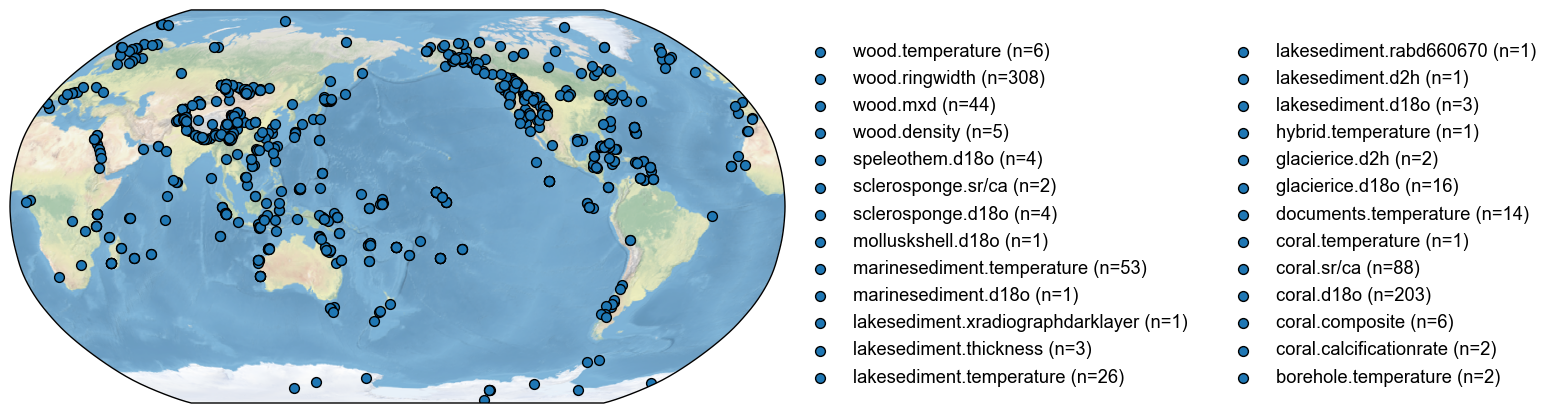

In [24]:
pdb = cfr.ProxyDatabase().from_df(
    df,
    pid_column='dataSetName',
    ptype_column='ptype',
    time_column='time_values',
    value_column='paleoData_values',
)
fig, ax = pdb.plot()

We need to modify the styles as below:

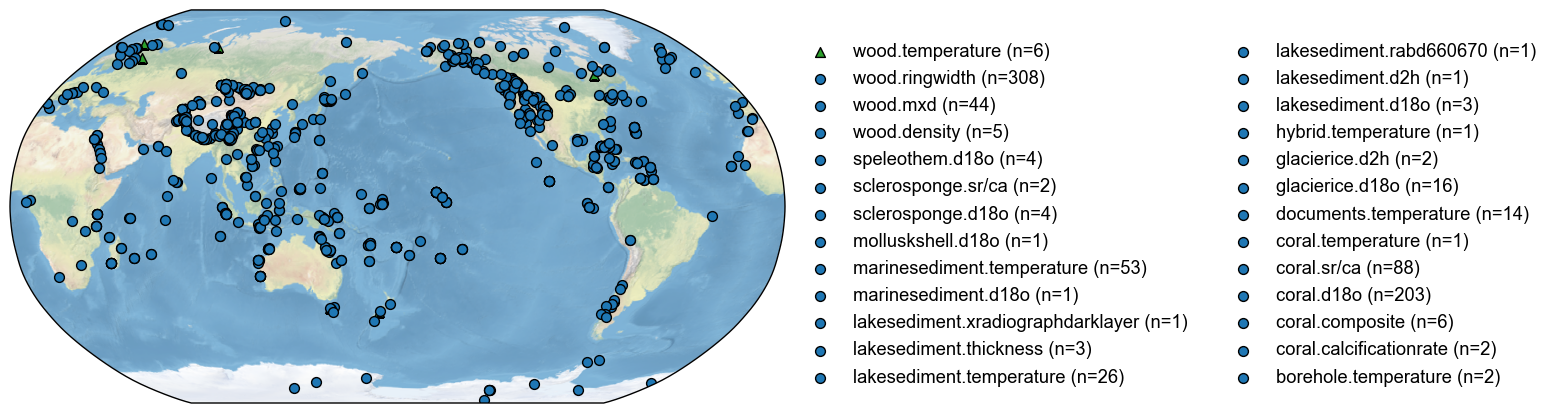

In [25]:
colors_dict = {
    'wood.temperature': 'tab:green',    
}

markers_dict = {
    'wood.temperature': '^',    
}

cfr.visual.STYLE.colors_dict.update(colors_dict)
cfr.visual.STYLE.markers_dict.update(markers_dict)

pdb = cfr.ProxyDatabase().from_df(
    df,
    pid_column='dataSetName',
    ptype_column='ptype',
    time_column='time_values',
    value_column='paleoData_values',
)
fig, ax = pdb.plot()

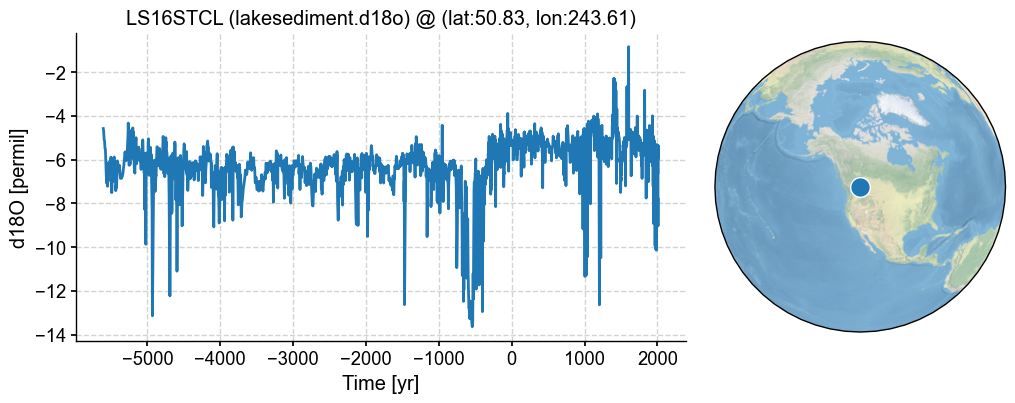

In [28]:
pobj = pdb[0]
fig, ax = pobj.plot()

In [ ]:
model_tas = cfr.ClimateField(da=)

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

In [ ]:
mdl = cfr.psm.Linear(pobj)

In [ ]:
sn_dict = {
    'dataSetName 001': [3, 4, 5],
    'dataSetName 002': [4, 5, 6],
    ...
}

In [ ]:
for pobj in pdb:
    sn = sn_dict[pobj.pid]
    mdl.calibrate(season_list=sn)
    pobj.psm = mdl
    pobj.pseudo = mdl.forward()

In [ ]:
pd.to_pickle(pdb, path)

In [ ]:
%%time
sn_list = [
    [3,4,5,6,7,8],
]
mdl.calibrate(season_list=sn_list)
mdl.calib_details

In [ ]:
pobj.psm = mdl

In [ ]:
%%time
pp = mdl.forward()

In [ ]:
pobj.pseudo = pp